Here I select 8 tropical orographic regions. For each region, I plot a cross-section of the mountain height perpendicular to the range; as well as a similar cross-section of the mean precip for the rainiest month of the year. The angle defining the orientation of each mountain range was chosen manually.

In [4]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *

In [5]:
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

In [6]:
mountains=         {"vietnam" :([102,113,10,18]       ,"Annamite range (Vietnam)",60+180,10),
                    "ghats"   :([70,80,9,17]          ,"Western Ghats",70,6),
                    "sumatra" :([95,106,-6,6]         ,"Bukit Barisan (Sumatra)",45,11),
                    "srilanka":([77,82.5,5,10]           ,"Sri Lanka",60+180,11),
                    "malaysia":([95,105,0,8]          ,"Malaysia",45+180,11),
                    "Candes"  :([360-82,360-68,-17,-9],"Central Andes",45+180,2),
                    "himalaya":([80,90,25,35]         ,"Himalaya",10,7)
                   }

mountains_upstream={"vietnam" :([108,111,12,17],"Annamite range (Vietnam)",60+180,10),
                    "ghats"   :([73,77,12,16],"Western Ghats",70,6),
                    "sumatra" :([98,102,-3,3],"Bukit Barisan (Sumatra)",45,11),
                    "srilanka":([80.5,82.5,6.5,10],"Sri Lanka",60+180,11),
                    "malaysia":([102,105,4,8],"Malaysia",45+180,11),
                    "Candes"  :([360-75,360-68,-15,-9],"Central Andes",45+180,2),
                    "himalaya":([80,90,26,30],"Himalaya",10,7)
                   }

# Data loading

## Monthly

In [7]:
trmmpr=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})
trmmpr.coords['longitude'] = trmmpr.coords['longitude'] % 360
trmmpr = trmmpr.sortby(trmmpr.longitude)
trmmpr = trmmpr.reindex(latitude=list(reversed(trmmpr.latitude)))
trmmpr = 86400*trmmpr.groupby("time.month").mean("time")

In [8]:
era5pr=   1000*e5_climatology('128_228_tp',years=range(2009,2019))
era5cape= e5_climatology('*_cape',years=range(2009,2019))

4.615552663803101
3.8433520793914795


In [9]:
trmmpr_seasmean={}
era5pr_seasmean={}
for i,name in enumerate(mountains):
    trmmpr_seasmean[name] = spatial_mean(trmmpr,mountains[name][0])
    era5pr_seasmean[name] = spatial_mean(era5pr,mountains[name][0])


In [10]:
def mean_rotate(var,box,angle,mnth):
    """Computes rotated means of a given variable"""
    window=var.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    if "month" in var.dims:
        window=window.sel(month=mnth)
    return rotate(np.array(window)[::-1],90-angle,reshape=False,cval=np.nan)

r_trmmpr   = {name:mean_rotate(trmmpr  ,mountains[name][0],mountains[name][2],mountains[name][3]) for name in mountains}
r_orogm    = {name:mean_rotate(orogm   ,mountains[name][0],mountains[name][2],mountains[name][3]) for name in mountains}
r_era5pr   = {name:mean_rotate(era5pr  ,mountains[name][0],mountains[name][2],mountains[name][3]) for name in mountains}
r_era5cape = {name:mean_rotate(era5cape,mountains[name][0],mountains[name][2],mountains[name][3]) for name in mountains}

## Precip extremes

In [11]:
pr_timeseries={name : xr.open_dataarray(glob.glob(os.path.join(SCRATCH+'processedData/precipCrossSections/',"e5.128_228_tp.daily.%s*.nc"%name))[0]) for name in mountains}
#pr_timeseries = e5_timeseries_precip({k:(v[0],v[3]) for k,v in mountains_upstream.items()},SCRATCH+'processedData/precipCrossSections/')


In [32]:
#%%time
#dictvars={name : {} for name in pr_timeseries}
#for name in pr_timeseries:
#    days = extreme_days(pr_timeseries[name],99)
#    dictvars[name]['trmmpr'] = trmm_get_pr(days,mountains[name][0]).mean('time')
#    dictvars[name]['trmmpr'].to_netcdf(SCRATCH+'processedData/precipCrossSections/trmm.pr.*%s.tp99mean.nc'%name)
#    for var in ['128_228_tp',"228_246_100u","228_247_100v","128_059_cape"]:
#        dictvars[name][var] = e5_get_extreme(pr_timeseries[name],99,mountains[name][0],var,tdisc=6).mean('time')
#        dictvars[name][var].to_netcdf(SCRATCH+'processedData/precipCrossSections/e5.%s.*%s.tp99mean.nc'%(var,name))
allvars=['128_228_tp',"228_246_100u","228_247_100v","128_059_cape"]
dictvars={name : {var : xr.open_dataarray(SCRATCH+'processedData/precipCrossSections/e5.%s.*%s.tp99mean.nc'%(var,name)) for var in allvars} for name in mountains}
for name in dictvars :
    dictvars[name]['trmmpr']=xr.open_dataarray(SCRATCH+'processedData/precipCrossSections/trmm.pr.*%s.tp99mean.nc'%name)
    

In [24]:
def sel_rotate(var,box, angle):
    """Computes rotated means of a given variable"""
    window=var.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    return rotate(np.array(window)[::-1],90-angle,reshape=False,cval=np.nan)

r_orogm    = {name:sel_rotate(orogm ,mountains[name][0],mountains[name][2]) for name in mountains}

In [25]:
dictvarsrotated={name : {} for name in mountains}
for name in mountains:
    for var in dictvars[name].keys():
        angle=mountains[name][2]
        dictvarsrotated[name][var] = rotate(np.array(dictvars[name][var])[::-1],90-angle,reshape=False,cval=np.nan)

## Upslope extremes

In [28]:
#u100_timeseries = e5_timeseries_sfc('228_246_100u',{k:(v[0],v[3]) for k,v in mountains_upstream.items()},SCRATCH+'processedData/precipCrossSections/',space_mean=False)
#v100_timeseries = e5_timeseries_sfc('228_247_100v',{k:(v[0],v[3]) for k,v in mountains_upstream.items()},SCRATCH+'processedData/precipCrossSections/',space_mean=False)
u100_timeseries={name : xr.open_dataarray(glob.glob(os.path.join(SCRATCH+'processedData/precipCrossSections/',"e5.228_246_100u.daily.%s*.nc"%name))[0]) for name in mountains}
v100_timeseries={name : xr.open_dataarray(glob.glob(os.path.join(SCRATCH+'processedData/precipCrossSections/',"e5.228_247_100v.daily.%s*.nc"%name))[0]) for name in mountains}


In [29]:
def upslopeflow(u,v,angle):
    return (u*np.sin(angle*np.pi/180)+v*np.cos(angle*np.pi/180)).mean(['latitude','longitude'])
upslopeflow_timeseries = {name : upslopeflow(u100_timeseries[name],v100_timeseries[name],mountains_upstream[name][2]) for name in mountains_upstream}



In [30]:
upslopeflow_timeseries={name:upslopeflow_timeseries[name].sel(time=(upslopeflow_timeseries[name]['time.year']<=2018)) for name in upslopeflow_timeseries}


In [31]:
#%%time
#dictvarsu={name : {} for name in mountains}
#for name in mountains:
#    try :
#        days = extreme_days(upslopeflow_timeseries[name],99)
#        dictvarsu[name]['trmmpr'] = trmm_get_pr(days,mountains[name][0]).mean('time')
#        dictvarsu[name]['trmmpr'].to_netcdf(SCRATCH+'processedData/precipCrossSections/trmm.pr.*%s.upslope99mean.nc'%name)
#    except ValueError:
#        print("FAIL")
#        pass
#    for var in ['128_228_tp',"228_246_100u","228_247_100v","128_059_cape"]:
#        dictvarsu[name][var] = e5_get_extreme(upslopeflow_timeseries[name],99,mountains[name][0],var,tdisc=6).mean('time')
#        dictvarsu[name][var].to_netcdf(SCRATCH+'processedData/precipCrossSections/e5.%s.*%s.upslope99mean.nc'%(var,name))
allvars=['128_228_tp',"228_246_100u","228_247_100v","128_059_cape"]
dictvarsu={name : {var : xr.open_dataarray(SCRATCH+'processedData/precipCrossSections/e5.%s.*%s.upslope99mean.nc'%(var,name)) for var in allvars} for name in mountains}
for name in dictvars :
    dictvars[name]['trmmpr']=xr.open_dataarray(SCRATCH+'processedData/precipCrossSections/trmm.pr.*%s.tp99mean.nc'%name)
    


In [33]:
dictvarsurotated={name : {} for name in mountains}
for name in mountains:
    for var in dictvarsu[name].keys():
        angle=mountains[name][2]
        dictvarsurotated[name][var] = rotate(np.array(dictvarsu[name][var])[::-1],90-angle,reshape=False,cval=np.nan)

## takes 2min

In [12]:
t=time.time()
winds={}
for i,name in enumerate(mountains):
    box,_,_,mnth = mountains[name]
    u = e5_climatology("*_100u",years=range(2010,2015),box=box,level=None,chunks=None,month=mnth)
    v = e5_climatology("*_100v",years=range(2010,2015),box=box,level=None,chunks=None,month=mnth)
    winds[name] = (u,v)
print(time.time()-t)

29.04481053352356


In [67]:
t=time.time()
u800 = e5_climatology("128_131_u",years=range(2010,2012),box=None,level=800.,chunks=None,month=None)
print(time.time()-t)   

26.47290325164795
27.17638349533081


In [68]:
t=time.time()
v800 = e5_climatology("128_132_v",years=range(2010,2012),box=None,level=800.,chunks=None,month=None)
print(time.time()-t)   

30.052379846572876
30.782237768173218


# Monthly means

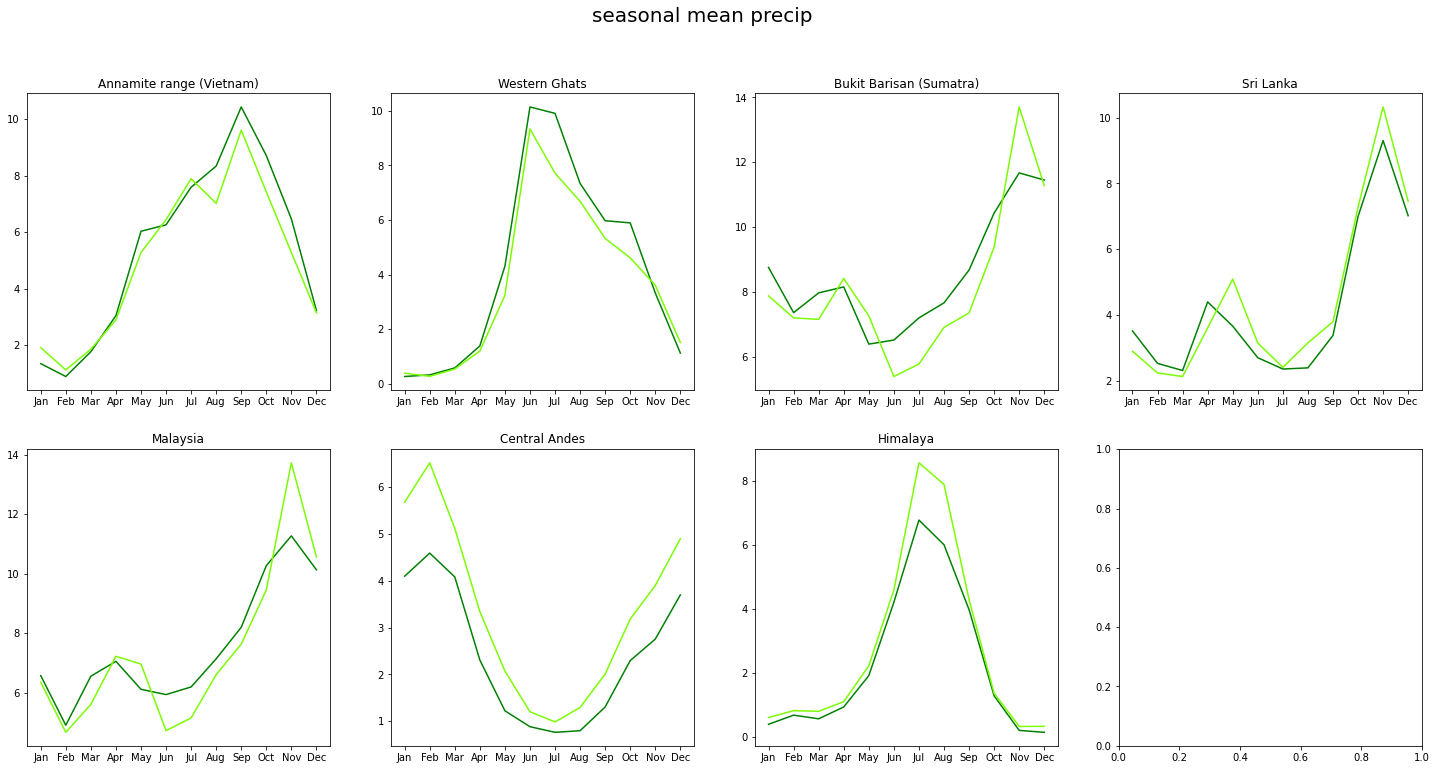

In [66]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)
mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,name in enumerate(mountains):
    ax[i].set_title(mountains[name][1])
    ax[i].plot(mnths,trmmpr_seasmean[name],color='green',label="TRMM pr")
    ax[i].plot(mnths,era5pr_seasmean[name],color='lawngreen',label="ERA5 pr")
    
fig.suptitle("seasonal mean precip",fontsize=20);None

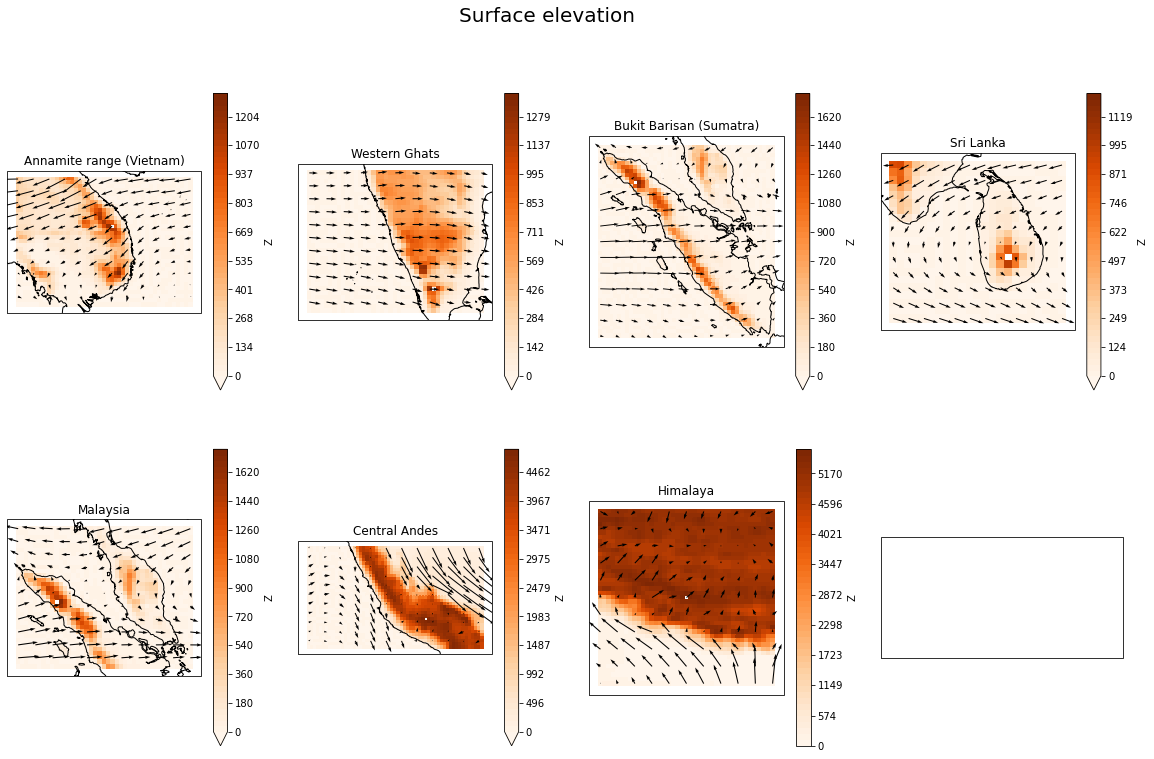

In [69]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
for i,name in enumerate(mountains):
    box,Lname,_,mnth = mountains[name]
    ax[i].coastlines()
    window=orogm.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    window.plot(ax=ax[i],transform=ccrs.PlateCarree(),cmap=plt.cm.Oranges,levels=np.linspace(0,window.max()))
    ax[i].set_title(Lname)
    
    u=u800.sel(month=mnth,longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    v=v800.sel(month=mnth,longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//10
    m=len(u.longitude)//10
    ax[i].quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k")

    
    
fig.suptitle("Surface elevation",fontsize=20);None

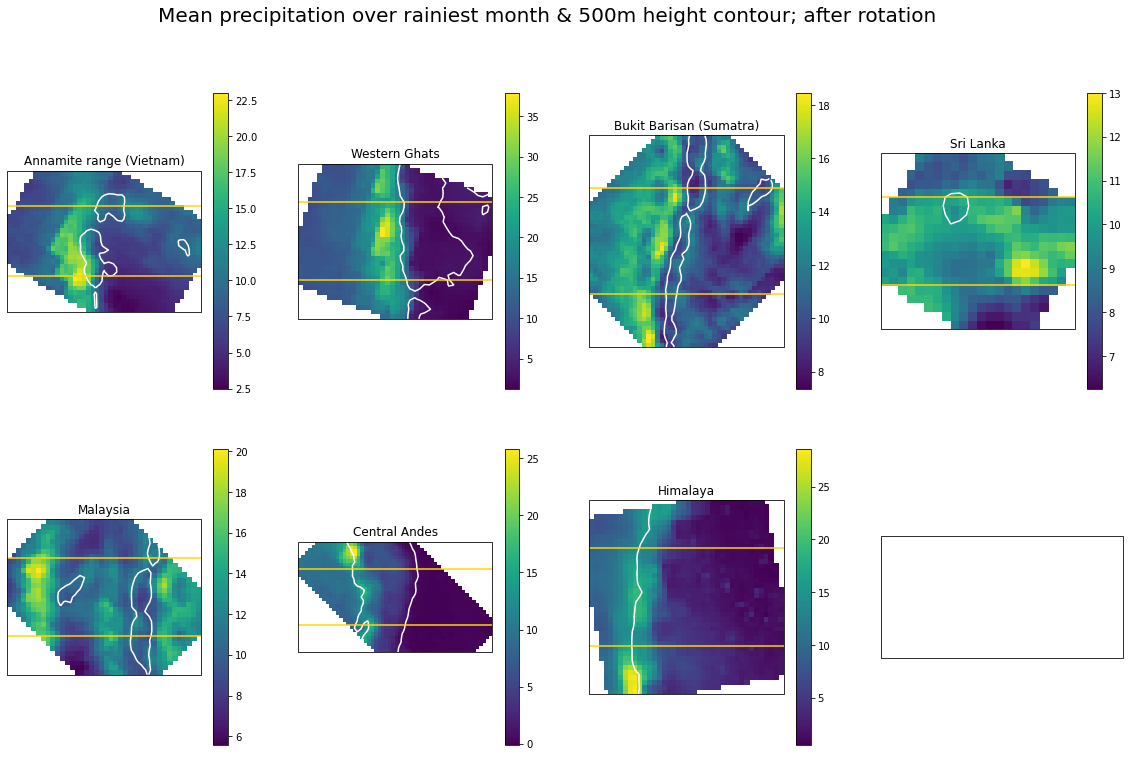

In [83]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
for i,name in enumerate(mountains):
    im=ax[i].pcolormesh(r_trmmpr[name],cmap=plt.cm.viridis)
    ax[i].contour(r_orogm[name],**{'levels':[500],'colors':['w']})
    ax[i].set_title(mountains[name][1])
    n=len(r_orogm[name])
    ax[i].axhline(n//4,color="gold")
    ax[i].axhline(3*n//4,color="gold")
    fig.colorbar(im, ax=ax[i])
    
fig.suptitle("Mean precipitation over rainiest month & 500m height contour; after rotation",fontsize=20);None

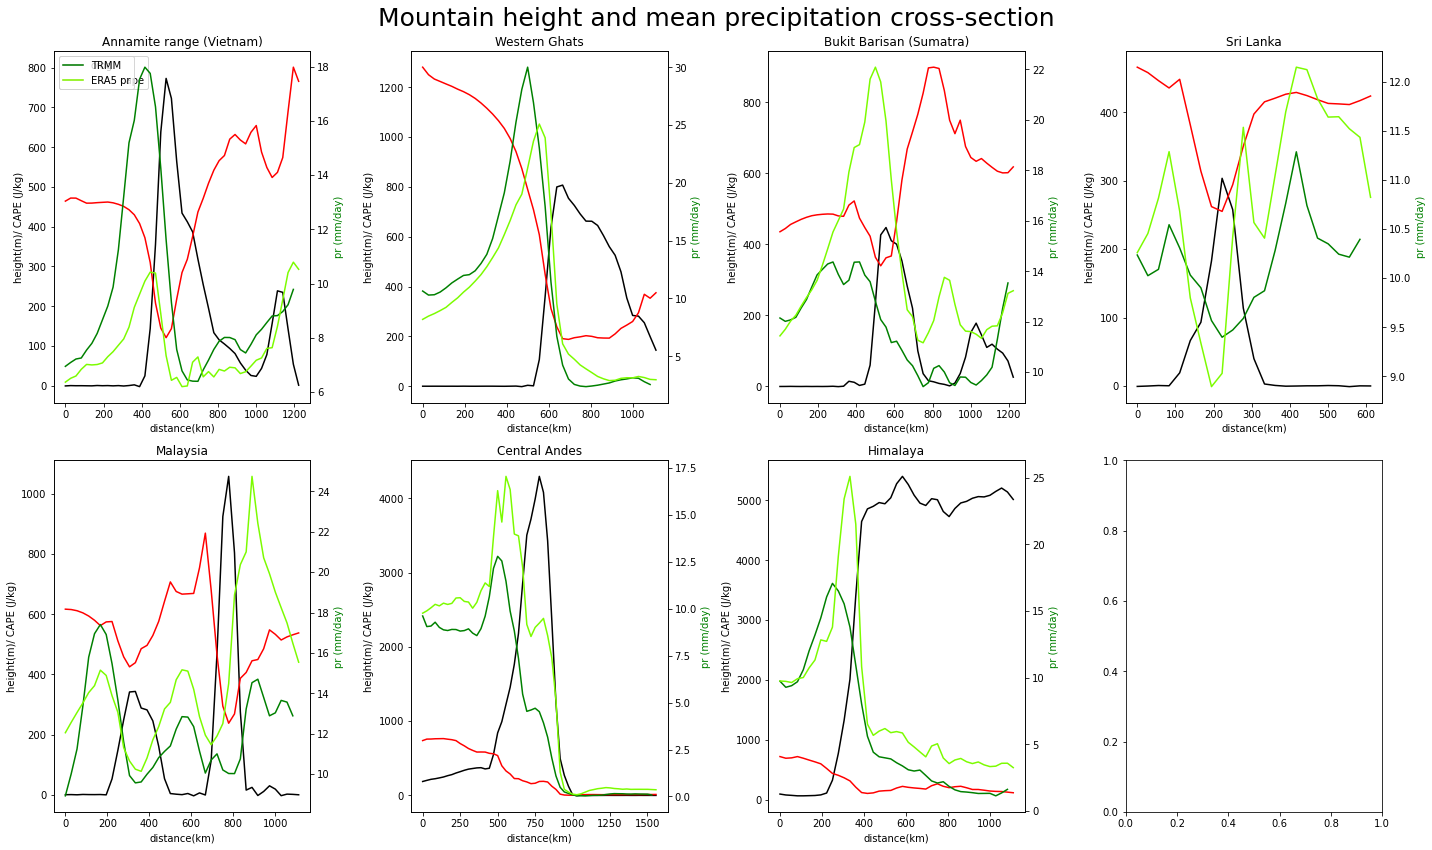

In [84]:
km_per_degreelat = 6370*np.pi/180
fig,ax = plt.subplots(2,4,figsize=(20,12))
ax = ax.reshape(-1)
for i,name in enumerate(mountains):
    ax[i].set_title(mountains[name][1])

    n,m=r_orogm[name].shape
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_orogm[name][n//4:3*n//4,:],axis=0),color='k',label='orog')
    ax[i].set_xlabel("distance(km)")
    ax[i].set_ylabel("height(m)/ CAPE (J/kg)")

    ax2=ax[i].twinx()
    ax2.set_ylabel('pr (mm/day)', color='g')
    n,m=r_trmmpr[name].shape
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_trmmpr[name][n//4:3*n//4,:],axis=0),'g',label='TRMM')
    
    n,m=r_era5pr[name].shape
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_era5pr[name][n//4:3*n//4,:],axis=0),color='lawngreen',label='ERA5 pr')
    
    
    n,m=r_era5cape[name].shape
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_era5cape[name][n//4:3*n//4,:],axis=0),'r',label='ERA5 cape')

    if i == 0:
        ax[i].legend()
        ax2.legend(loc="upper left")
        
fig.suptitle("Mountain height and mean precipitation cross-section",fontsize=25)
fig.tight_layout()



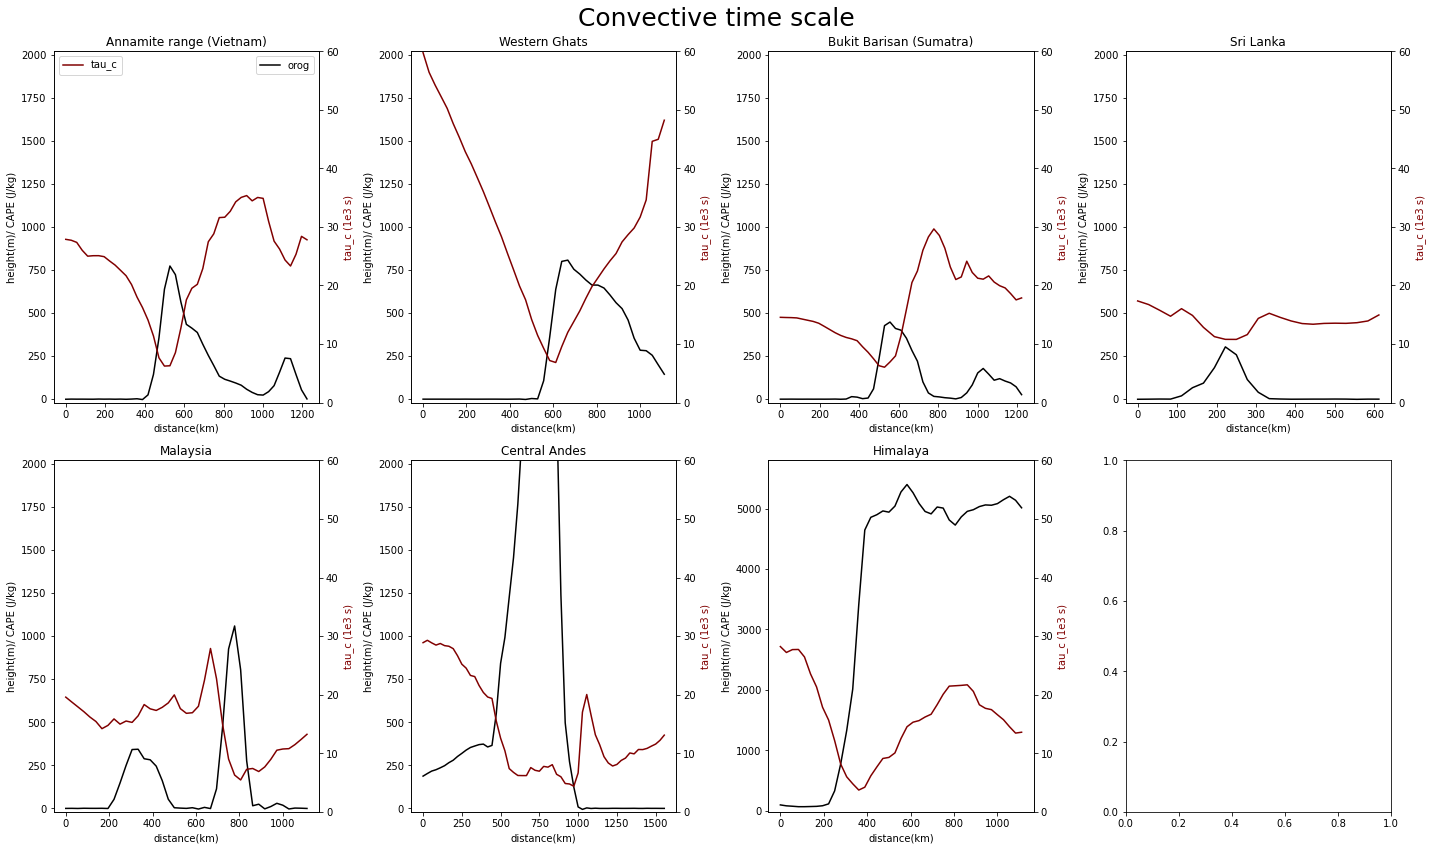

In [86]:
km_per_degreelat = 6370*np.pi/180
fig,ax = plt.subplots(2,4,figsize=(20,12))
ax = ax.reshape(-1)
for i,name in enumerate(mountains):
    ax[i].set_title(mountains[name][1])

    n,m=r_orogm[name].shape
    #ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],r_orogm[i][n//2,:])
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_orogm[name][n//4:3*n//4,:],axis=0),color='k',label='orog')
    ax[i].set_xlabel("distance(km)")
    ax[i].set_ylabel("height(m)/ CAPE (J/kg)")

    ax2=ax[i].twinx()
    ax2.set_ylabel('tau_c (1e3 s)', color='maroon')
    
    n,m=r_era5pr[name].shape
    pr = np.nanmean(r_era5pr[name][n//4:3*n//4,:],axis=0)
    cape = np.nanmean(r_era5cape[name][n//4:3*n//4,:],axis=0)
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],86400*1e4*cape/pr/2.26e6 / 1000,color='maroon',label='tau_c')

    if i == 0:
        ax[i].legend()
        ax2.legend(loc="upper left")
    if i < 6:
        ax[i].set_ylim(-20,2020)
    else:
        ax[i].set_ylim(-20,5800)
    ax2.set_ylim(0,60)
    
fig.suptitle("Convective time scale",fontsize=25)
fig.tight_layout()



# Daily data (extremes)

## Precip extremes

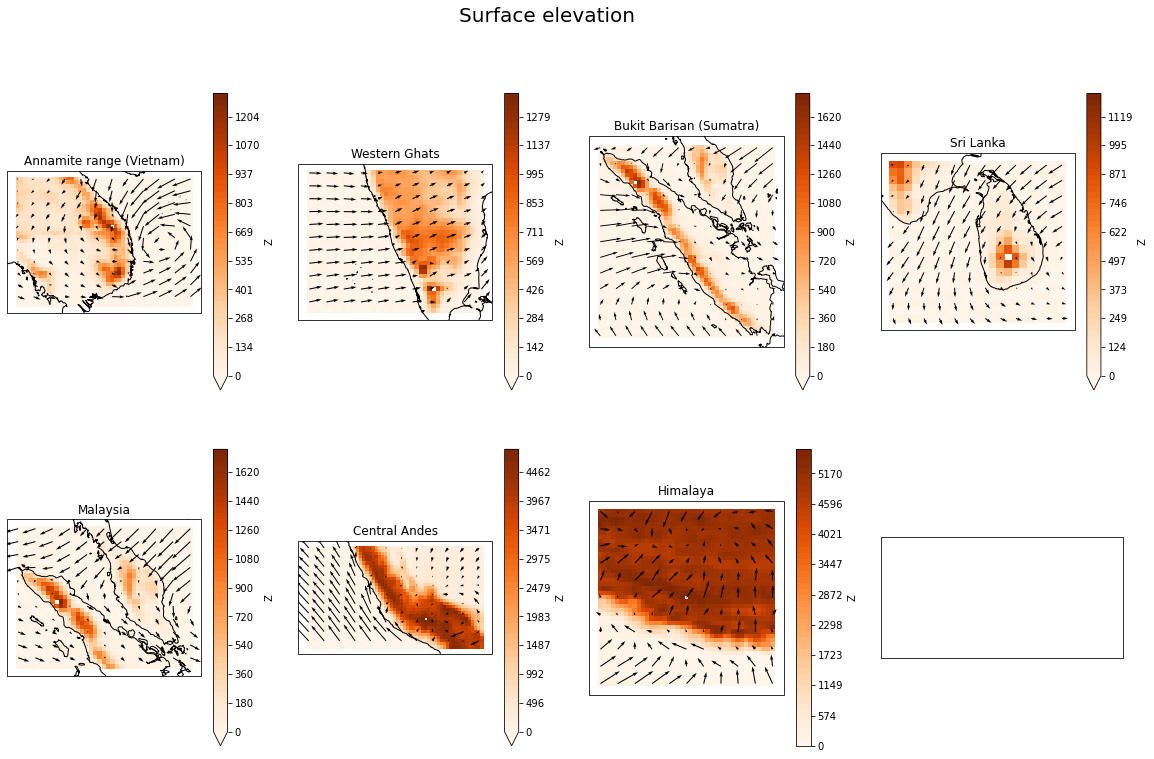

In [24]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
i=0
for name,(box,lname,_,mnth) in mountains.items():
    ax[i].coastlines()
    window=orogm.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    window.plot(ax=ax[i],transform=ccrs.PlateCarree(),cmap=plt.cm.Oranges,levels=np.linspace(0,window.max()))
    ax[i].set_title(lname)
    
    u=dictvars[name]["228_246_100u"]
    v=dictvars[name]["228_247_100v"]
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//10
    m=len(u.longitude)//10
    ax[i].quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k")
    i+=1
    
    
fig.suptitle("Surface elevation",fontsize=20);None

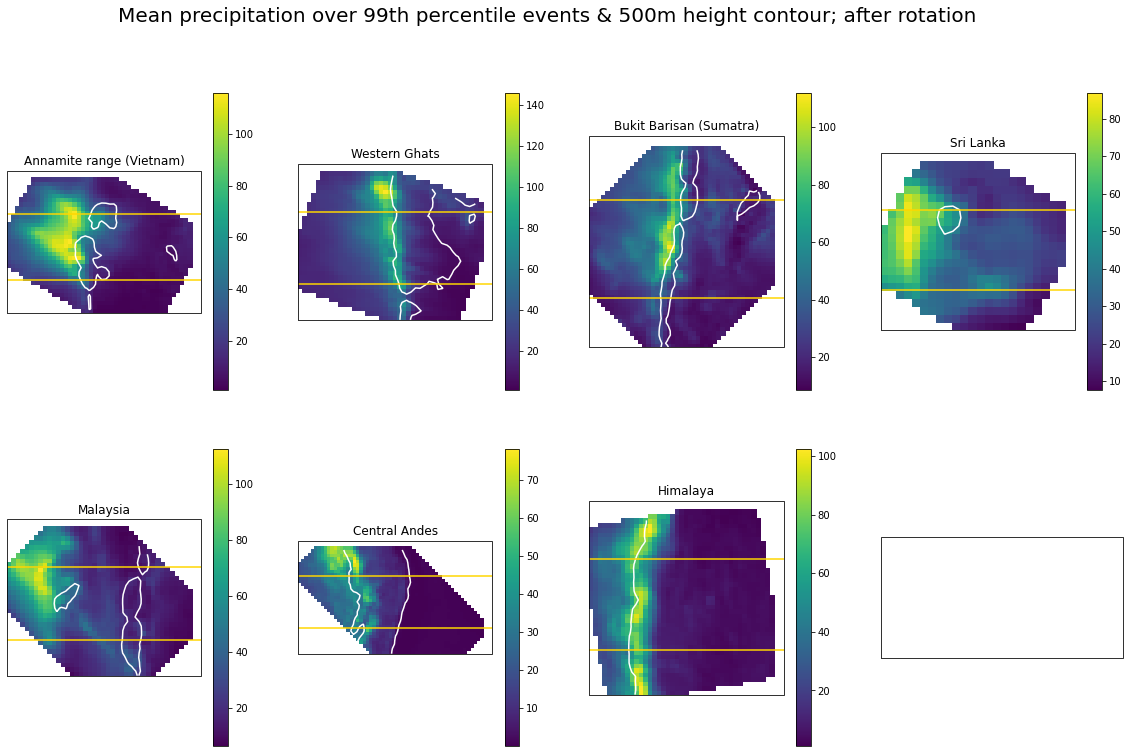

In [27]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)

for i,name in enumerate(mountains):
    im=ax[i].pcolormesh(dictvarsrotated[name]['128_228_tp'],cmap=plt.cm.viridis)
    ax[i].contour(r_orogm[name],**{'levels':[500],'colors':['w']})
    ax[i].set_title(mountains[name][1])
    n=len(r_orogm[name])
    ax[i].axhline(n//4,color="gold")
    ax[i].axhline(3*n//4,color="gold")
    fig.colorbar(im, ax=ax[i])
    
fig.suptitle("Mean precipitation over 99th percentile events & 500m height contour; after rotation",fontsize=20);None

## Upslope flow extremes

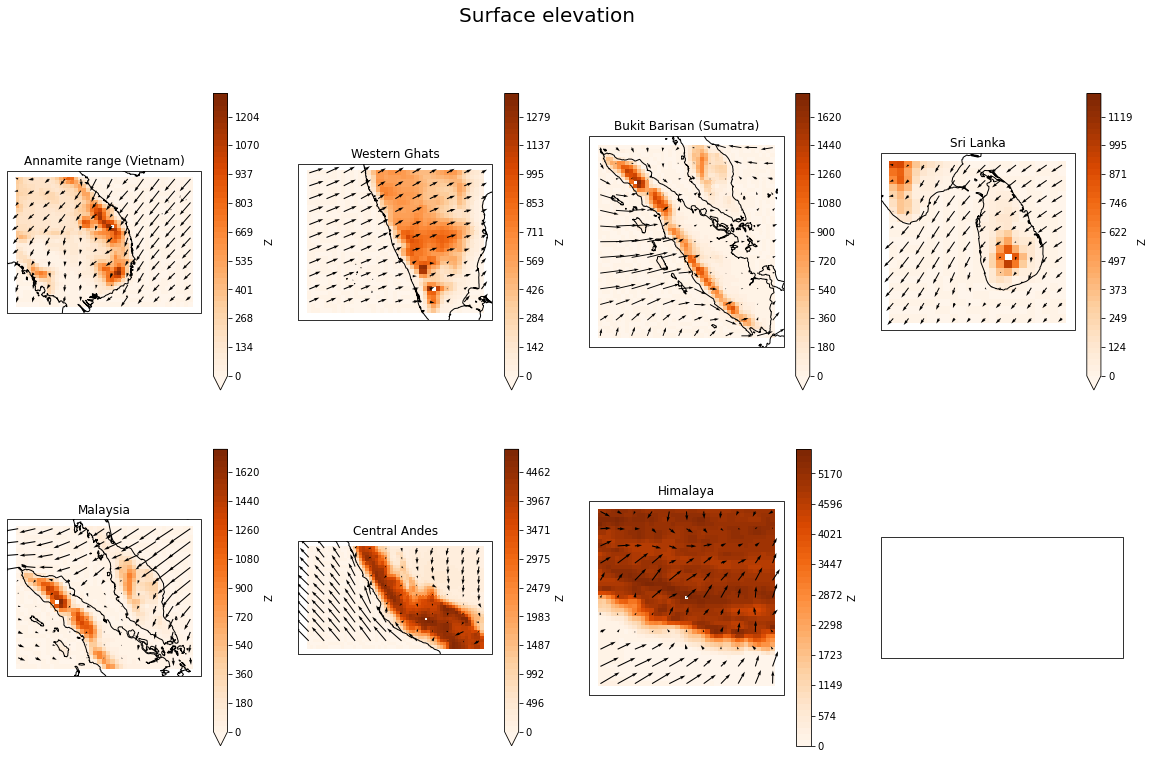

In [51]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
i=0
for name,(box,lname,_,mnth) in mountains.items():
    ax[i].coastlines()
    window=orogm.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    window.plot(ax=ax[i],transform=ccrs.PlateCarree(),cmap=plt.cm.Oranges,levels=np.linspace(0,window.max()))
    ax[i].set_title(lname)
    
    u=dictvarsu[name]["228_246_100u"]
    v=dictvarsu[name]["228_247_100v"]
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//10
    m=len(u.longitude)//10
    ax[i].quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k")
    i+=1
    
    
fig.suptitle("Surface elevation",fontsize=20);None

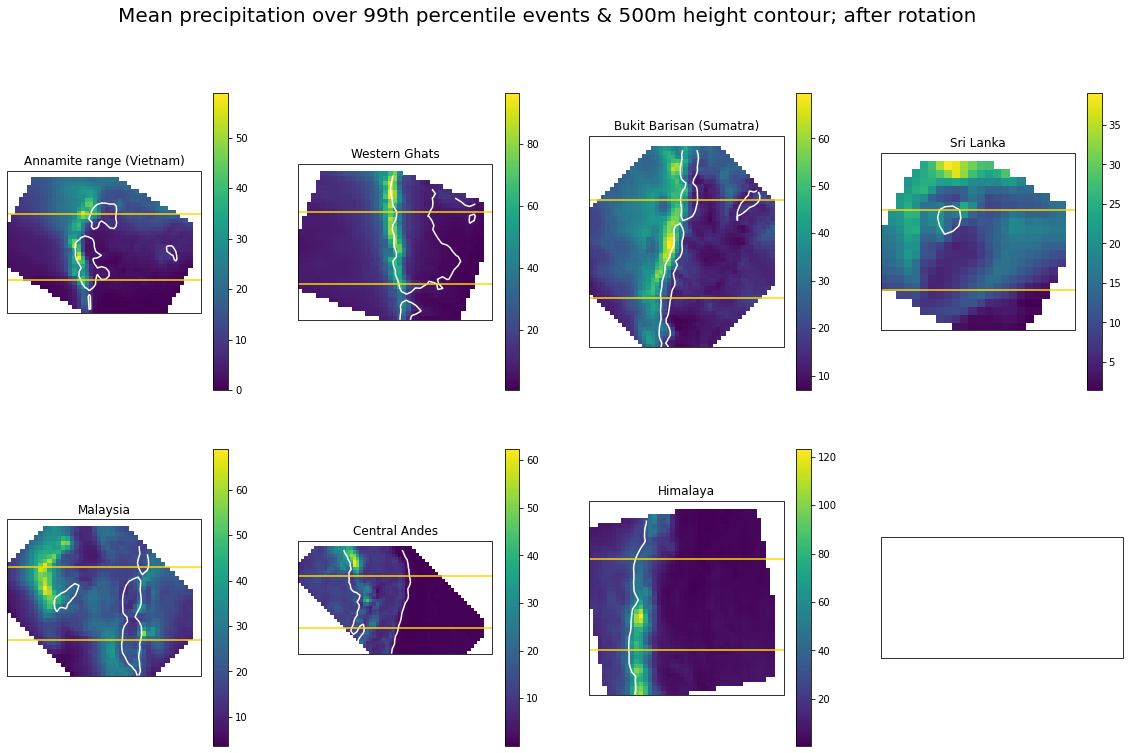

In [59]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)

for i,name in enumerate(mountains):
    im=ax[i].pcolormesh(dictvarsurotated[name]['128_228_tp'],cmap=plt.cm.viridis)
    ax[i].contour(r_orogm[name],**{'levels':[500],'colors':['w']})
    ax[i].set_title(mountains[name][1])
    n=len(r_orogm[name])
    ax[i].axhline(n//4,color="gold")
    ax[i].axhline(3*n//4,color="gold")
    fig.colorbar(im, ax=ax[i])
    
fig.suptitle("Mean precipitation over 99th percentile events & 500m height contour; after rotation",fontsize=20);None

# Comparison

## Precip

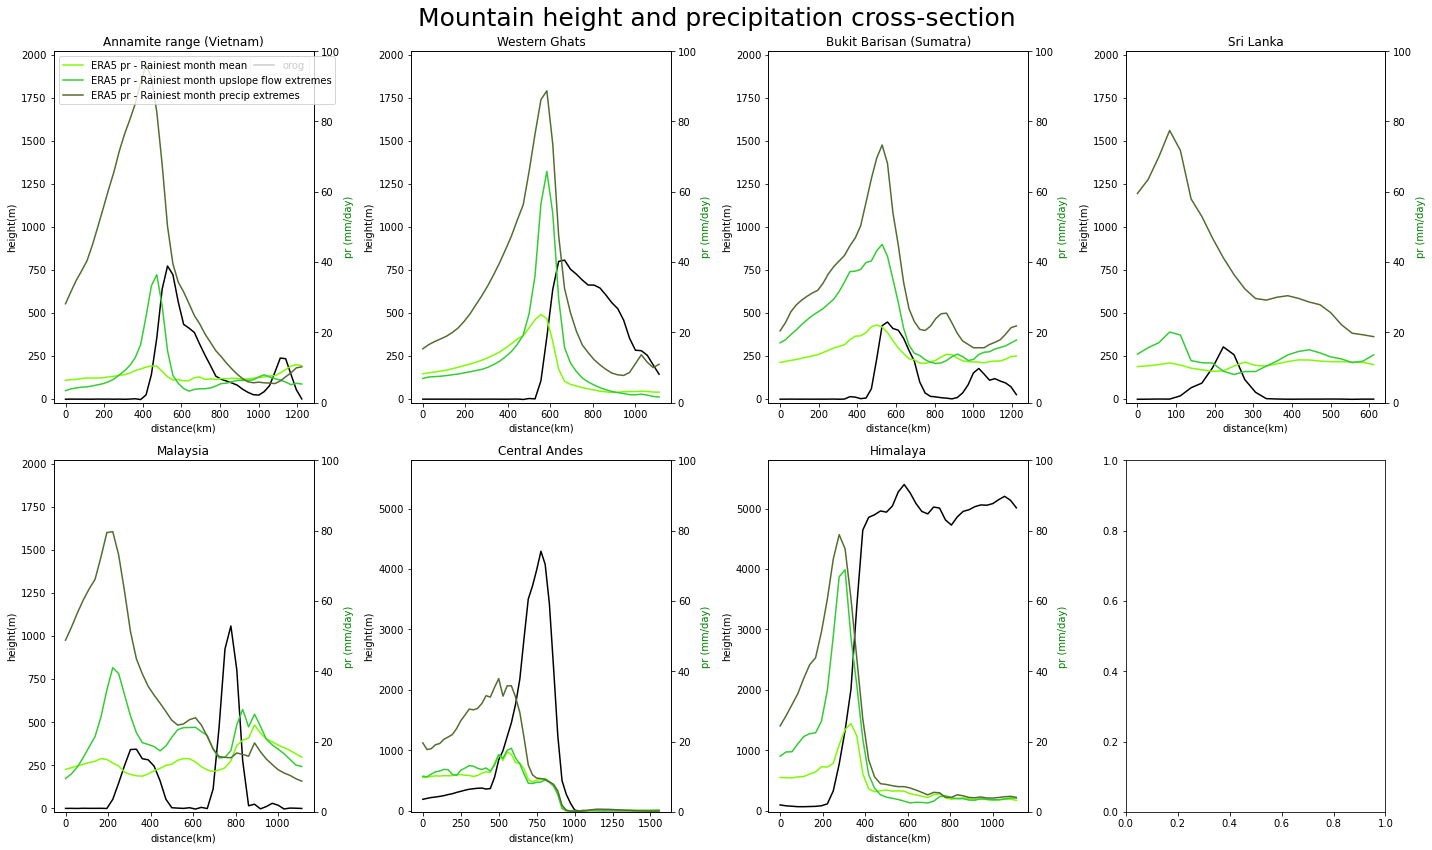

In [94]:
km_per_degreelat = 6370*np.pi/180
fig,ax = plt.subplots(2,4,figsize=(20,12))
ax = ax.reshape(-1)
for i,name in enumerate(mountains):
    ax[i].set_title(mountains[name][1])

    n,m=r_orogm[name].shape
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_orogm[name][n//4:3*n//4,:],axis=0),color='k',label='orog')
    ax[i].set_xlabel("distance(km)")
    ax[i].set_ylabel("height(m)")

    ax2=ax[i].twinx()
    ax2.set_ylabel('pr (mm/day)', color='g')

    n,m=r_era5pr[name].shape
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_era5pr[name][n//4:3*n//4,:],axis=0),color='lawngreen',label='ERA5 pr - Rainiest month mean')
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(dictvarsurotated[name]['128_228_tp'][n//4:3*n//4,:],axis=0),color='limegreen',label='ERA5 pr - Rainiest month upslope flow extremes')
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(dictvarsrotated[name]['128_228_tp'][n//4:3*n//4,:],axis=0),color='darkolivegreen',label='ERA5 pr - Rainiest month precip extremes')
    

    if i == 0:
        ax[i].legend()
        ax2.legend(loc="upper left")
    if i < 5:
        ax[i].set_ylim(-20,2020)
    else:
        ax[i].set_ylim(-20,5800)
    ax2.set_ylim(0,100)
        
fig.suptitle("Mountain height and precipitation cross-section",fontsize=25)
fig.tight_layout()



## CAPE

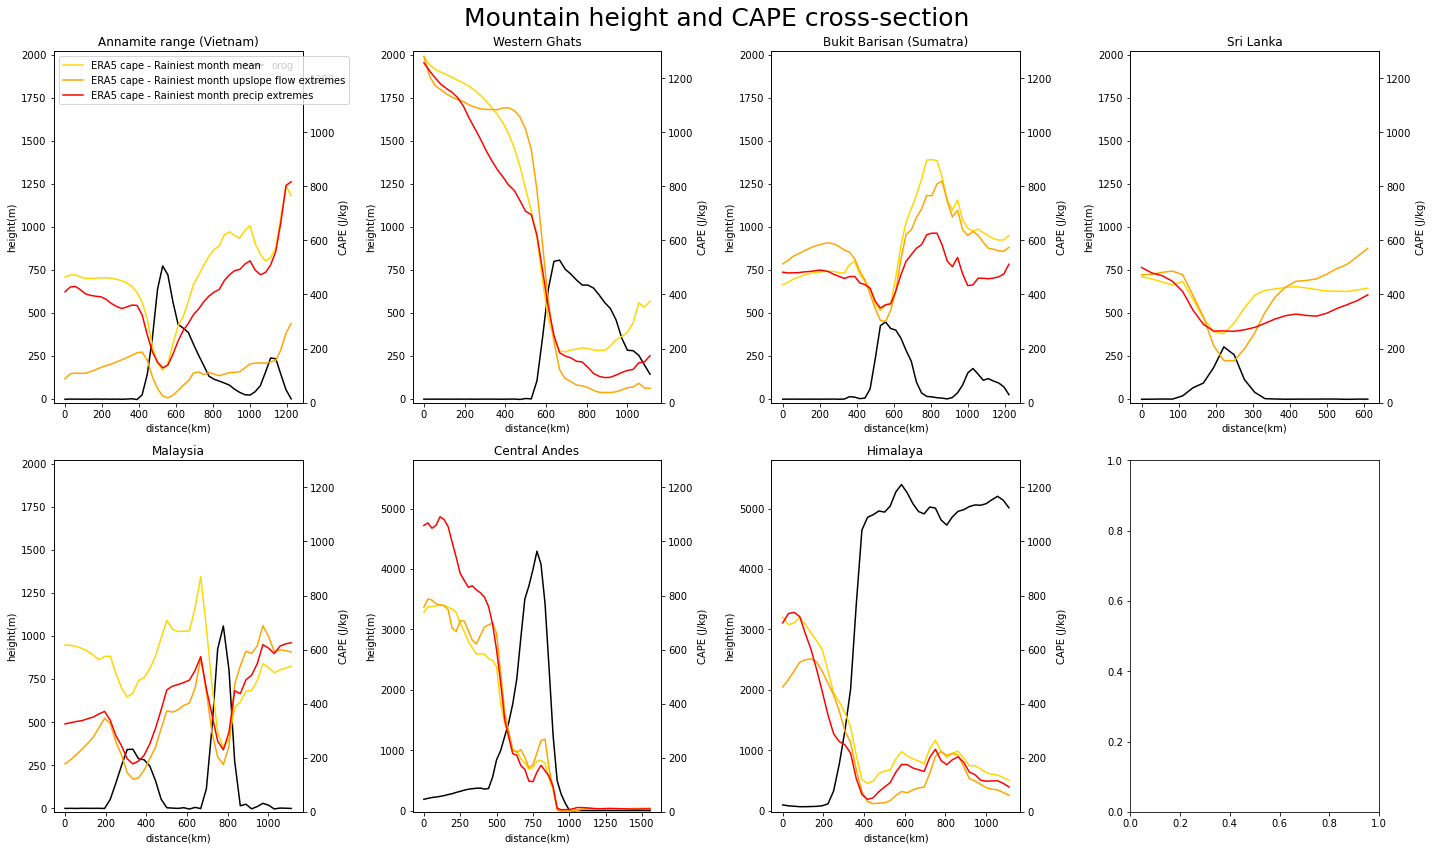

In [98]:
km_per_degreelat = 6370*np.pi/180
fig,ax = plt.subplots(2,4,figsize=(20,12))
ax = ax.reshape(-1)
for i,name in enumerate(mountains):
    ax[i].set_title(mountains[name][1])

    n,m=r_orogm[name].shape
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_orogm[name][n//4:3*n//4,:],axis=0),color='k',label='orog')
    ax[i].set_xlabel("distance(km)")
    ax[i].set_ylabel("height(m)")

    ax2=ax[i].twinx()
    ax2.set_ylabel('CAPE (J/kg)', color='k')

    n,m=r_era5cape[name].shape
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_era5cape[name][n//4:3*n//4,:],axis=0),color='gold',label='ERA5 cape - Rainiest month mean')
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(dictvarsurotated[name]['128_059_cape'][n//4:3*n//4,:],axis=0),color='orange',label='ERA5 cape - Rainiest month upslope flow extremes')
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(dictvarsrotated[name]['128_059_cape'][n//4:3*n//4,:],axis=0),color='red',label='ERA5 cape - Rainiest month precip extremes')
    

    if i == 0:
        ax[i].legend()
        ax2.legend(loc="upper left")
    if i < 5:
        ax[i].set_ylim(-20,2020)
    else:
        ax[i].set_ylim(-20,5800)
    ax2.set_ylim(0,1300)
        
fig.suptitle("Mountain height and CAPE cross-section",fontsize=25)
fig.tight_layout()



## Convective timescale

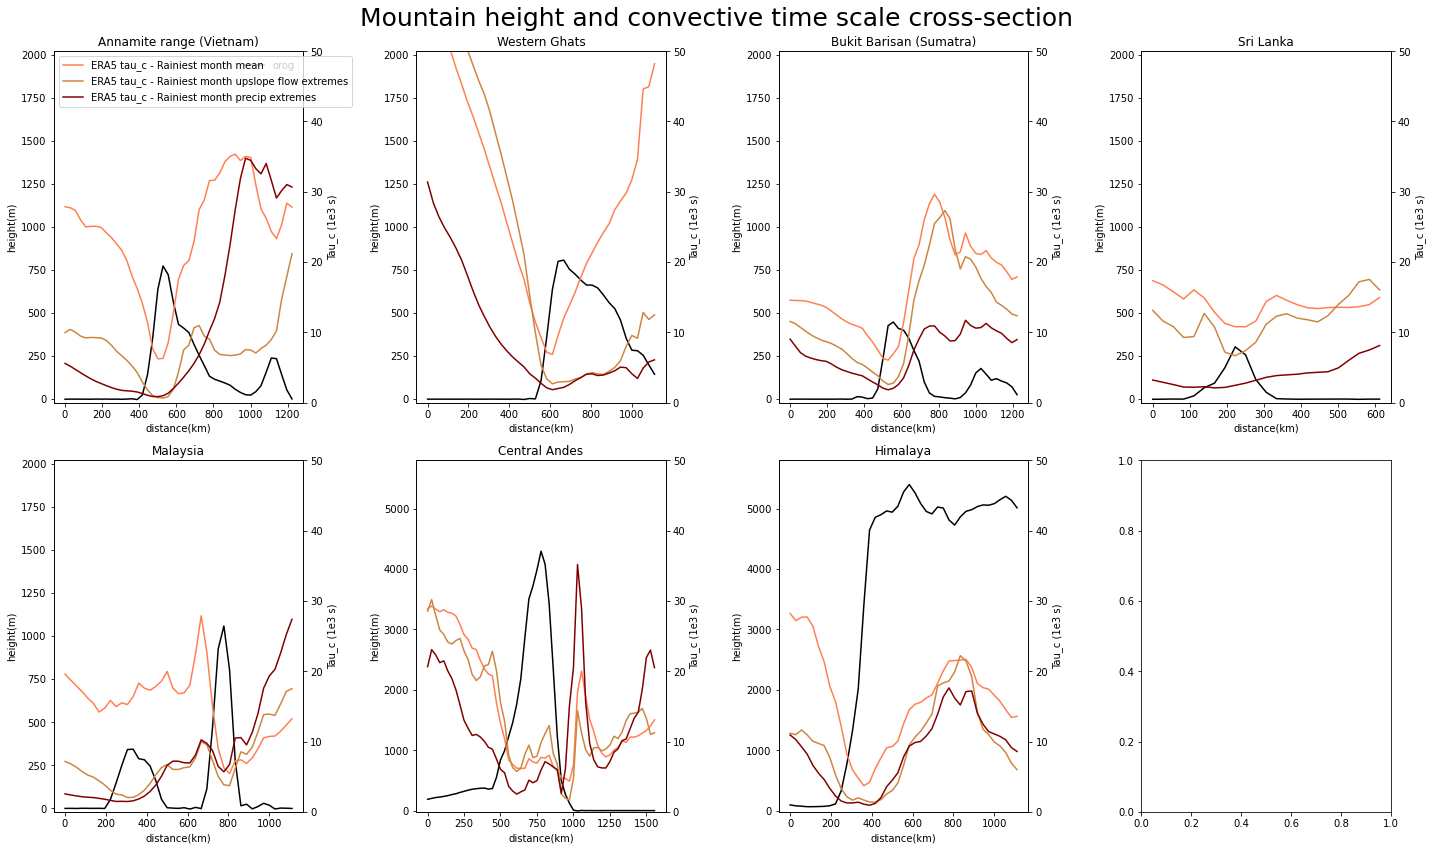

In [103]:
km_per_degreelat = 6370*np.pi/180
fig,ax = plt.subplots(2,4,figsize=(20,12))
ax = ax.reshape(-1)
for i,name in enumerate(mountains):
    ax[i].set_title(mountains[name][1])

    n,m=r_orogm[name].shape
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_orogm[name][n//4:3*n//4,:],axis=0),color='k',label='orog')
    ax[i].set_xlabel("distance(km)")
    ax[i].set_ylabel("height(m)")

    ax2=ax[i].twinx()
    ax2.set_ylabel('Tau_c (1e3 s)', color='k')

    n,m=r_era5cape[name].shape
    
    pr = np.nanmean(r_era5pr[name][n//4:3*n//4,:],axis=0)
    cape = np.nanmean(r_era5cape[name][n//4:3*n//4,:],axis=0)
    factor = 2.26e6/(86400*1e4) #convert pr to J/kg / s : convert to mm/s, multiply by Lv, divide by atmospheric mass
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],1/(1000*factor)*np.nanmean(r_era5cape[name][n//4:3*n//4,:],axis=0)                      /np.nanmean(r_era5pr[name][n//4:3*n//4,:],axis=0)                      ,color='coral',label='ERA5 tau_c - Rainiest month mean')
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],1/(1000*factor)*np.nanmean(dictvarsurotated[name]['128_059_cape'][n//4:3*n//4,:],axis=0)/np.nanmean(dictvarsurotated[name]['128_228_tp'][n//4:3*n//4,:],axis=0),color='peru',label='ERA5 tau_c - Rainiest month upslope flow extremes')
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],1/(1000*factor)*np.nanmean(dictvarsrotated[name]['128_059_cape'][n//4:3*n//4,:],axis=0) /np.nanmean(dictvarsrotated[name]['128_228_tp'][n//4:3*n//4,:],axis=0) ,color='maroon',label='ERA5 tau_c - Rainiest month precip extremes')
    

    if i == 0:
        ax[i].legend()
        ax2.legend(loc="upper left")
    if i < 5:
        ax[i].set_ylim(-20,2020)
    else:
        ax[i].set_ylim(-20,5800)
    ax2.set_ylim(0,50)
        
fig.suptitle("Mountain height and convective time scale cross-section",fontsize=25)
fig.tight_layout()

